In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [55]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fc37d15b050>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [26]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

ConversionError: Failed to convert value(s) to axis units: '2017-08-23'

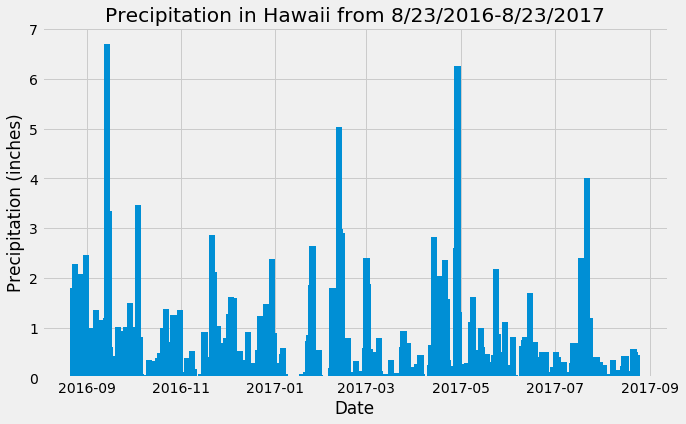

In [69]:
#LATEST DATE
#first_date = session.query(measurement.date).order_by(measurement.date).all()
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()


#print(last_date)
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the date and precipitation scores
date = dt.datetime(2016, 8, 22)
sel = [measurement.date, measurement.prcp]
last_12_months = session.query(*sel).filter(measurement.date>date).all()
#last_12_months

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_12_months, columns=['date', 'prcp'])
df['date']=pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_df = df.sort_values(by='date', ascending=False)
sorted_df.head(-10)
# Use Pandas Plotting with Matplotlib to plot the data
#sorted_df.plot.bar()
#plt.show()

# Use Pandas Plotting with Matplotlib to plot the data
from matplotlib.dates import MonthLocator, DateFormatter
#reset index so the date is on its own column again



start_date = "2017-08-23"
end_date = "2016-08-23"

new_df = sorted_df.reset_index()
new_df = new_df.dropna()
fig, ax = plt.subplots(figsize=(10, 6))
# Add x-axis and y-axis
ax.bar(new_df['date'],
       new_df['prcp'],width=4)
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Precipitation in Hawaii from 8/23/2016-8/23/2017")
#set the xlimits to correct time frame
ax.set_xlim(start_date,end_date)
#Set the xaxis ticks to increment by 1 month
ax.xaxis.set_major_locator(MonthLocator(bymonthday=1))
#format date to show year-month-day
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [75]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_mean = new_df['prcp'].mean()
prcp_median = new_df['prcp'].median()
prcp_mode = new_df['prcp'].mode()
print(f"Mean {prcp_mean}, Median:  {prcp_median}")
new_df['prcp'].describe()

Mean 0.17727857496288904, Median:  0.02


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [85]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(func.count(station.id)).all()
number_of_stations

[(9)]

In [120]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#engine.execute('SELECT station FROM station').fetchall()
sel = [measurement.station,
      func.count(measurement.station)]
most_active = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

most_active



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [128]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [measurement.station,
       func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]
most_active_stats = session.query(*sel).filter(measurement.station == "USC00519281").all()

most_active_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

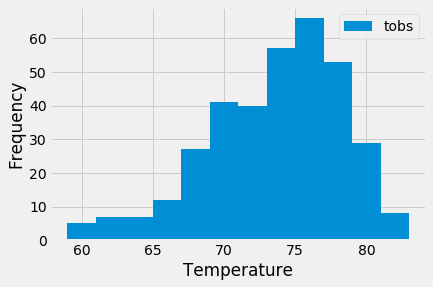

In [176]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.tobs, func.count(measurement.tobs)]
last_12_months_tobs = session.query(*sel).filter(measurement.date>date).filter(measurement.station == "USC00519281").\
    group_by(measurement.tobs).all()
last_12_months_tobs

df_tobs = pd.DataFrame(last_12_months_tobs[0], columns=['Temperature'])

tobs = session.query(measurement.tobs).filter(measurement.date>date).\
    filter(measurement.station == "USC00519281").all()
tobs
df_tob = pd.DataFrame(tobs, columns=['Temperature'])
df_tob.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.legend(['tobs'])

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
